+----------+-------------------+--------------+-----+--------+----------+
|      name|     classification|pokedex_number|type1|   type2|generation|
+----------+-------------------+--------------+-----+--------+----------+
|  Squirtle|Tiny Turtle Pokémon|             7|water|    NULL|         1|
| Wartortle|     Turtle Pokémon|             8|water|    NULL|         1|
| Blastoise|  Shellfish Pokémon|             9|water|    NULL|         1|
|   Psyduck|       Duck Pokémon|            54|water|    NULL|         1|
|   Golduck|       Duck Pokémon|            55|water|    NULL|         1|
|   Poliwag|    Tadpole Pokémon|            60|water|    NULL|         1|
| Poliwhirl|    Tadpole Pokémon|            61|water|    NULL|         1|
| Poliwrath|    Tadpole Pokémon|            62|water|fighting|         1|
| Tentacool|  Jellyfish Pokémon|            72|water|  poison|         1|
|Tentacruel|  Jellyfish Pokémon|            73|water|  poison|         1|
+----------+-------------------+------

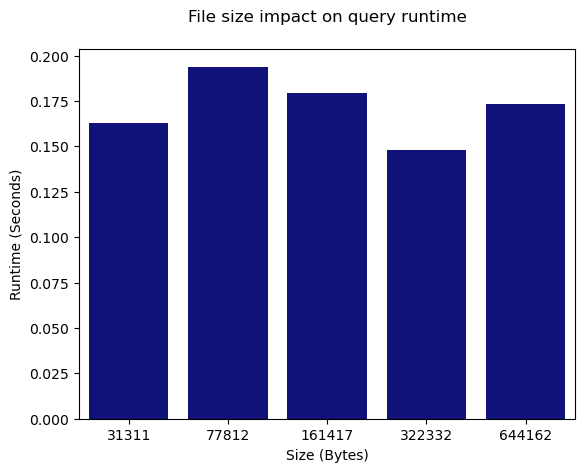

In [23]:
from pyspark.sql import SparkSession
import time
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from google.cloud import storage

spark = SparkSession.builder.appName("WS78").getOrCreate()
datasets = ["gs://dataproc-staging-us-central1-734514214178-tdqcky8f/data/gen1.csv", "gs://dataproc-staging-us-central1-734514214178-tdqcky8f/data/quad.csv", "gs://dataproc-staging-us-central1-734514214178-tdqcky8f/data/gen1-3.csv", "gs://dataproc-staging-us-central1-734514214178-tdqcky8f/data/pokemon.csv", "gs://dataproc-staging-us-central1-734514214178-tdqcky8f/data/double.csv"]
times = []

def get_file_sizes(bucket_name, prefix=""):
    file_sizes = []
    # Create a client
    client = storage.Client()

    # Get the bucket
    bucket = client.bucket(bucket_name)

    # List files with the given prefix
    files = client.list_blobs(bucket_name, prefix=prefix)

    for file in files:
        if file.name.endswith('.csv') and file.size > 0:
            file_sizes.append(file.size)
    
    return file_sizes

for path in datasets:
    df = spark.read.csv(path, header=True, inferSchema=True)

    # Temp view (table view that's not saved)
    df.createOrReplaceTempView("pokemon_tbl")

    # Run query with start and end time
    start = time.time()
    spark.sql("""SELECT name, classification, pokedex_number, type1, type2, generation 
    FROM pokemon_tbl 
    WHERE generation = '1' AND type1 = 'water'
    ORDER BY pokedex_number""").show(10)
    end = time.time()
    
    # Collect total runtime for the current file
    total_time = end - start
    times.append(total_time)
    print(f"Processing {path} took {total_time:.4f} seconds")
    
# Collect file sizes
sizes = get_file_sizes("dataproc-staging-us-central1-734514214178-tdqcky8f", "data/")
sizes.sort()

# Create dataframe for sizes and runtimes to use in Seaborn plot
time_size_df = pd.DataFrame({
    'runtime': times,
    'size': sizes
})
    
sns.barplot(
    x='size',
    y='runtime',
    data=time_size_df,
    color='darkblue'
)
plt.xlabel("Size (Bytes)")
plt.ylabel("Runtime (Seconds)")
plt.title("File size impact on query runtime", pad=20);